In [1]:
!pip install nflows==0.14


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=b487fa6a7dcb466de55cc5197ba90ff42b3cad4589c93c4af8247cdf9151e183
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [2]:
#Install a working nflows version in Colab
!pip install --quiet nflows==0.14 torch torchvision --upgrade
!pip install --quiet statsmodels pandas matplotlib seaborn scikit-learn shap tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 979.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
import torch
import nflows
print("Torch:", torch.__version__)
print("nflows imported OK")


Torch: 2.9.1+cu128
nflows imported OK


In [4]:
#Mount Drive and create the folder structure described earlier
from google.colab import drive
drive.mount('/content/drive')

import os
BASE = '/content/drive/My Drive/NAFM_Project'
paths = ['data','models','results','plots','shap','report']
for p in paths:
    os.makedirs(os.path.join(BASE, p), exist_ok=True)

print("Folders created at:", BASE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folders created at: /content/drive/My Drive/NAFM_Project


In [5]:
#Generate a synthetic multivariate time series (5 variables, >1000 timesteps)
import numpy as np
import pandas as pd
import os

np.random.seed(42)
T = 1400   # total timesteps (>= 1000)
vars_n = 5

t = np.arange(T)

# build components: trend + seasonal + heteroscedastic noise + cross-variable coupling
data = np.zeros((T, vars_n))
for i in range(vars_n):
    trend = 0.01*(i+1)*t                          # linear trend scaled per variable
    seasonal = 2.0 * np.sin(2*np.pi*(t/(50 + 10*i)))  # variable-specific seasonality
    # heteroscedastic noise amplitude grows with time and variable index
    noise_scale = 0.5 + 0.002*(t) + 0.1*(i)
    noise = noise_scale * np.random.randn(T)
    # cross-coupling: add small weighted version of previous variable
    coupling = 0.1 * (np.roll(np.sin(0.02*t + i), 1))
    data[:, i] = trend + seasonal + coupling + noise

# Build dataframe with timestamp
df = pd.DataFrame(data, columns=[f'var_{i+1}' for i in range(vars_n)])
df['time'] = pd.date_range(start='2000-01-01', periods=T, freq='D')
df = df[['time'] + [f'var_{i+1}' for i in range(vars_n)]]

# Save CSV to Drive
out_path = os.path.join('/content/drive/My Drive/NAFM_Project/data', 'simulated_timeseries.csv')
df.to_csv(out_path, index=False)
print("Saved dataset to:", out_path)
df.head()


Saved dataset to: /content/drive/My Drive/NAFM_Project/data/simulated_timeseries.csv


,time,var_1,var_2,var_3,var_4,var_5
0,2000-01-01,0.277367,-0.693001,0.029592,0.152701,-0.115919
1,2000-01-02,0.191258,0.636269,2.190718,-0.663317,0.020397
2,2000-01-03,0.845815,1.257199,0.753452,-0.387376,0.108031
3,2000-01-04,1.540901,1.199960,0.002404,-0.184581,1.366696
4,2000-01-05,0.890554,1.586306,0.843432,0.875497,1.052045


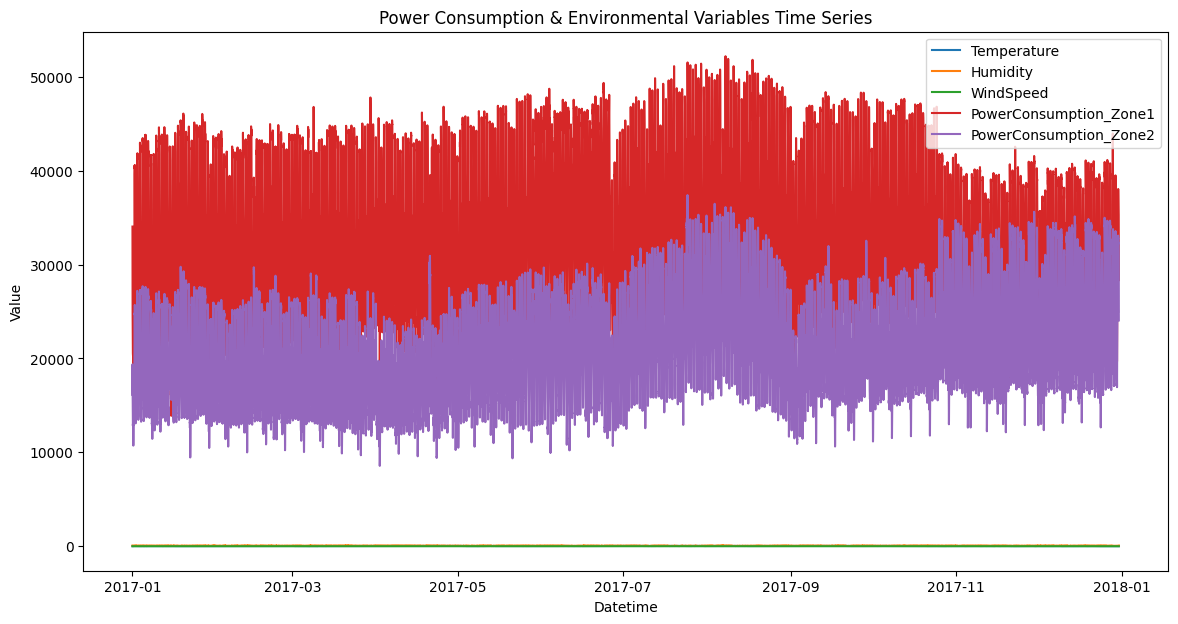

Plot saved to: /content/drive/MyDrive/NAFM_Project/plots/powerconsumption.png


In [6]:
#Quick plot of the dataset to confirm trends/seasonality
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/NAFM_Project/data/powerconsumption.csv')

# Convert Datetime → proper timestamp
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Select 5 variables for plotting (you can change these later)
vars_to_plot = [
    'Temperature',
    'Humidity',
    'WindSpeed',
    'PowerConsumption_Zone1',
    'PowerConsumption_Zone2'
]

plt.figure(figsize=(14,7))
for v in vars_to_plot:
    plt.plot(df['Datetime'], df[v], label=v)

plt.legend()
plt.title("Power Consumption & Environmental Variables Time Series")
plt.xlabel("Datetime")
plt.ylabel("Value")
save_path = '/content/drive/MyDrive/NAFM_Project/plots/powerconsumption.png'
plt.savefig(save_path, bbox_inches='tight')
plt.show()

print("Plot saved to:", save_path)


In [7]:
#Build X (inputs) and Y (targets)

import numpy as np

# Input features (8)
feature_cols = [
    'Temperature',
    'Humidity',
    'WindSpeed',
    'GeneralDiffuseFlows',
    'DiffuseFlows',
    'PowerConsumption_Zone1',
    'PowerConsumption_Zone2',
    'PowerConsumption_Zone3'
]

# Target features (3)
target_cols = [
    'PowerConsumption_Zone1',
    'PowerConsumption_Zone2',
    'PowerConsumption_Zone3'
]

# Convert to arrays
X_data = df[feature_cols].values.astype(np.float32)
Y_data = df[target_cols].values.astype(np.float32)

# Train-test split
train_ratio = 0.8
n_train = int(len(df) * train_ratio)

X_train_raw = X_data[:n_train]
Y_train_raw = Y_data[:n_train]

X_test_raw  = X_data[n_train:]
Y_test_raw  = Y_data[n_train:]

# Window creation
def create_windows(X, Y, input_len=30, horizon=1):
    X_list, Y_list = [], []
    for i in range(len(X) - input_len - horizon + 1):
        X_list.append(X[i:i+input_len])
        Y_list.append(Y[i+input_len:i+input_len+horizon])
    return np.array(X_list), np.array(Y_list)

input_len = 30
horizon = 1

# Build training windows
X_train, Y_train = create_windows(X_train_raw, Y_train_raw, input_len, horizon)

# Build test windows
X_test, Y_test = create_windows(
    np.vstack([X_train_raw[-input_len:], X_test_raw]),
    np.vstack([Y_train_raw[-input_len:], Y_test_raw]),
    input_len, horizon
)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


X_train: (41902, 30, 8)
Y_train: (41902, 1, 3)
X_test: (10484, 30, 8)
Y_test: (10484, 1, 3)


In [8]:
#VAR Baseline (Targets only)

import pandas as pd
from statsmodels.tsa.api import VAR

# Use only training target vars
train_df_target = pd.DataFrame(Y_train_raw, columns=target_cols)

var_model = VAR(train_df_target)
lag_order = 5
var_res = var_model.fit(lag_order)
print(var_res.summary())

# Forecast H steps
H = len(Y_test_raw)
forecast = var_res.forecast(train_df_target.values[-lag_order:], steps=H)

forecast_df = pd.DataFrame(forecast, columns=target_cols)

# Confidence intervals (Gaussian)
cov = var_res.resid.cov().values
z = 1.645  # 90% interval
std = np.sqrt(np.diag(cov))

baseline_out = pd.concat([
    forecast_df,
    forecast_df - z * std,
    forecast_df + z * std
], axis=1)

baseline_out.columns = (
    target_cols +
    [c+"_lower" for c in target_cols] +
    [c+"_upper" for c in target_cols]
)

baseline_out.to_csv('/content/drive/MyDrive/NAFM_Project/results/baseline_forecast.csv', index=False)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 19, Nov, 2025
Time:                     17:52:47
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    34.2813
Nobs:                     41927.0    HQIC:                   34.2745
Log likelihood:          -896876.    FPE:                7.65375e+14
AIC:                      34.2714    Det(Omega_mle):     7.64499e+14
--------------------------------------------------------------------
Results for equation PowerConsumption_Zone1
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                           347.707171        10.205897           34.069           0.000
L1.PowerConsumption_Zone1         1.264713         0.005307          238.318           0

In [9]:


import torch
from torch.utils.data import DataLoader, TensorDataset
from nflows import transforms, distributions, flows
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ------------------------------
# 1) Normalize inputs and targets
# ------------------------------

X_mean = X_train.mean(axis=(0,1), keepdims=True)
X_std = X_train.std(axis=(0,1), keepdims=True) + 1e-6

Y_mean = Y_train.mean(axis=(0,1), keepdims=True)
Y_std = Y_train.std(axis=(0,1), keepdims=True) + 1e-6

X_train_n = (X_train - X_mean) / X_std
Y_train_n = (Y_train - Y_mean) / Y_std

# Flatten
X_train_flat = X_train_n.reshape(X_train_n.shape[0], -1)
Y_train_flat = Y_train_n.reshape(Y_train_n.shape[0], -1)

input_dim = 3
context_dim = X_train_flat.shape[1]

# ------------------------------
# 2) Build stable flow
# ------------------------------

hidden = 64
num_layers = 3

transform_list = []

for _ in range(num_layers):
    transform_list.append(
        transforms.MaskedAffineAutoregressiveTransform(
            features=input_dim,
            hidden_features=hidden,
            context_features=context_dim
        )
    )
    transform_list.append(
        transforms.BatchNorm(features=input_dim)
    )

transform = transforms.CompositeTransform(transform_list)
base = distributions.StandardNormal([input_dim])

flow = flows.Flow(transform, base).to(device)

# ------------------------------
# 3) Train
# ------------------------------

optimizer = torch.optim.Adam(flow.parameters(), lr=5e-4)

dataset = TensorDataset(
    torch.tensor(Y_train_flat).float(),
    torch.tensor(X_train_flat).float()
)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(20):
    total = 0
    for y, x in loader:
        y = y.to(device)
        x = x.to(device)

        loss = -flow.log_prob(y, context=x).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total += loss.item()

    print(f"Epoch {epoch+1}, Loss={total:.4f}")

torch.save({
    "state_dict": flow.state_dict(),
    "X_mean": X_mean,
    "X_std": X_std,
    "Y_mean": Y_mean,
    "Y_std": Y_std
}, "/content/drive/MyDrive/NAFM_Project/models/nafm_model_stable.pth")

print("Stable NAFM model saved.")


Using: cpu
Epoch 1, Loss=-330.6238
Epoch 2, Loss=-878.1932
Epoch 3, Loss=-1069.4234
Epoch 4, Loss=-1157.8388
Epoch 5, Loss=-1229.4689
Epoch 6, Loss=-1274.9625
Epoch 7, Loss=-1331.7776
Epoch 8, Loss=-1355.3767
Epoch 9, Loss=-1390.7239
Epoch 10, Loss=-1396.2060
Epoch 11, Loss=-1431.3376
Epoch 12, Loss=-1444.1970
Epoch 13, Loss=-1460.5818
Epoch 14, Loss=-1491.7621
Epoch 15, Loss=-1487.5822
Epoch 16, Loss=-1496.7338
Epoch 17, Loss=-1519.9283
Epoch 18, Loss=-1532.1692
Epoch 19, Loss=-1542.5210
Epoch 20, Loss=-1545.6046
Stable NAFM model saved.


In [11]:
#Forecast using Stable NAFM

import torch
import numpy as np
import pandas as pd

# Load model + normalization stats
checkpoint = torch.load(
    '/content/drive/MyDrive/NAFM_Project/models/nafm_model_stable.pth',
    map_location=device,
    weights_only=False
)

flow.load_state_dict(checkpoint["state_dict"])
flow.eval()

X_mean = checkpoint["X_mean"]
X_std = checkpoint["X_std"]
Y_mean = checkpoint["Y_mean"]
Y_std = checkpoint["Y_std"]

# Normalize test input
X_test_n = (X_test - X_mean) / X_std
X_test_flat = X_test_n.reshape(X_test_n.shape[0], -1)

n_samples = 200
means, lowers, uppers = [], [], []

with torch.no_grad():
    for i in range(len(X_test_flat)):
        context = torch.tensor(X_test_flat[i:i+1]).float().to(device)

        samples = flow.sample(n_samples, context=context).cpu().numpy()

        if samples.ndim == 3:
            samples = samples.squeeze(0)

        # Un-normalize predictions
        samples = samples * Y_std.reshape(1,3) + Y_mean.reshape(1,3)

        means.append(samples.mean(axis=0))
        lowers.append(np.percentile(samples, 5, axis=0))
        uppers.append(np.percentile(samples, 95, axis=0))

means = np.vstack(means)
lowers = np.vstack(lowers)
uppers = np.vstack(uppers)

out = pd.DataFrame(means, columns=target_cols)
out[[c+"_lower" for c in target_cols]] = lowers
out[[c+"_upper" for c in target_cols]] = uppers

out.to_csv('/content/drive/MyDrive/NAFM_Project/results/nafm_forecast.csv', index=False)

print("Stable NAFM forecasts saved:", out.shape)


Stable NAFM forecasts saved: (10484, 9)


In [13]:
#Evaluation for 3 targets

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error   # <-- IMPORTANT IMPORT

baseline = pd.read_csv('/content/drive/MyDrive/NAFM_Project/results/baseline_forecast.csv')
nafm = pd.read_csv('/content/drive/MyDrive/NAFM_Project/results/nafm_forecast.csv')

min_len = min(len(Y_test), len(baseline), len(nafm))
Y_true = Y_test[:min_len].reshape(min_len, 3)
baseline = baseline[:min_len]
nafm = nafm[:min_len]

metrics = []

for i, col in enumerate(target_cols):
    true_vals = Y_true[:, i]

    mse_b = mean_squared_error(true_vals, baseline[col])
    mse_n = mean_squared_error(true_vals, nafm[col])

    cov_b = np.mean((true_vals >= baseline[col+"_lower"]) & (true_vals <= baseline[col+"_upper"]))
    cov_n = np.mean((true_vals >= nafm[col+"_lower"]) & (true_vals <= nafm[col+"_upper"]))

    wid_b = np.mean(baseline[col+"_upper"] - baseline[col+"_lower"])
    wid_n = np.mean(nafm[col+"_upper"] - nafm[col+"_lower"])

    metrics.append({
        "Variable": col,
        "MSE_Baseline": mse_b,
        "MSE_NAFM": mse_n,
        "Coverage_Baseline": cov_b,
        "Coverage_NAFM": cov_n,
        "IntervalWidth_Baseline": wid_b,
        "IntervalWidth_NAFM": wid_n
    })

metrics_df = pd.DataFrame(metrics)
metrics_df


,Variable,MSE_Baseline,MSE_NAFM,Coverage_Baseline,Coverage_NAFM,IntervalWidth_Baseline,IntervalWidth_NAFM
0,PowerConsumption_Zone1,5.091004e+07,4.850585e+07,0.056372,0.925982,1336.929740,23310.328831
1,PowerConsumption_Zone2,3.793399e+07,1.770332e+06,0.038535,0.929607,887.290846,4195.834289
2,PowerConsumption_Zone3,6.206205e+07,2.120413e+06,0.016787,0.930370,950.674513,4017.848077


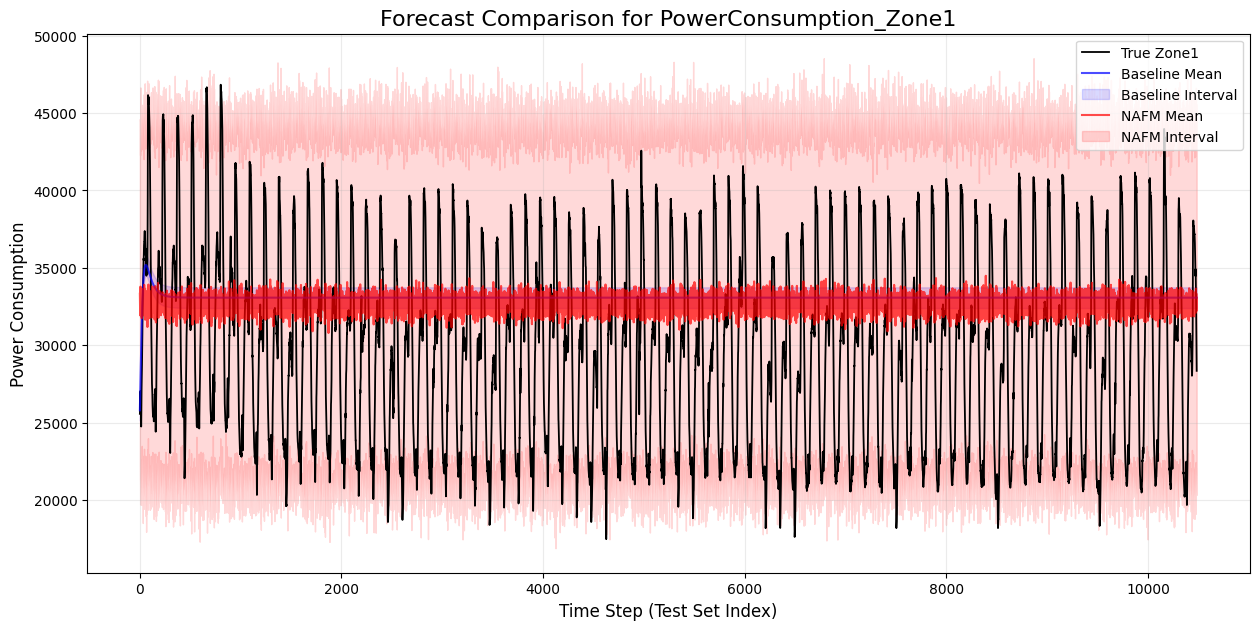

Plot saved to: /content/drive/MyDrive/NAFM_Project/plots/forecast_zone1.png


In [14]:
#Forecast Plot for Zone 1 Only

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load forecasts
baseline = pd.read_csv('/content/drive/MyDrive/NAFM_Project/results/baseline_forecast.csv')
nafm = pd.read_csv('/content/drive/MyDrive/NAFM_Project/results/nafm_forecast.csv')

# Align lengths
min_len = min(len(Y_test), len(baseline), len(nafm))
Y_true_zone1 = Y_test[:min_len].reshape(min_len, 3)[:, 0]   # Zone1 only

baseline = baseline[:min_len]
nafm = nafm[:min_len]

# Build the plot
plt.figure(figsize=(15, 7))

# True values
plt.plot(Y_true_zone1, label="True Zone1", color="black", linewidth=1.3)

# Baseline prediction
plt.plot(baseline["PowerConsumption_Zone1"], label="Baseline Mean", color="blue", alpha=0.7)
plt.fill_between(
    np.arange(min_len),
    baseline["PowerConsumption_Zone1_lower"],
    baseline["PowerConsumption_Zone1_upper"],
    color="blue",
    alpha=0.15,
    label="Baseline Interval"
)

# NAFM prediction
plt.plot(nafm["PowerConsumption_Zone1"], label="NAFM Mean", color="red", alpha=0.7)
plt.fill_between(
    np.arange(min_len),
    nafm["PowerConsumption_Zone1_lower"],
    nafm["PowerConsumption_Zone1_upper"],
    color="red",
    alpha=0.15,
    label="NAFM Interval"
)

plt.title("Forecast Comparison for PowerConsumption_Zone1", fontsize=16)
plt.xlabel("Time Step (Test Set Index)", fontsize=12)
plt.ylabel("Power Consumption", fontsize=12)
plt.legend()
plt.grid(alpha=0.25)

# Save figure
save_path = "/content/drive/MyDrive/NAFM_Project/plots/forecast_zone1.png"
plt.savefig(save_path, bbox_inches="tight")
plt.show()

print("Plot saved to:", save_path)
